True owner, i just download and run to see what it look like : https://github.com/soham2707/AnimeGAN/blob/master/AnimeGAN.ipynb

In [33]:
!pip install opendatasets --upgrade --quiet

In [34]:
import opendatasets as od



dataset_url = 'https://www.kaggle.com/splcher/animefacedataset'

od.download(dataset_url)

Skipping, found downloaded files in "./animefacedataset" (use force=True to force download)


In [35]:
import os



DATA_DIR = '/kaggle/working/animefacedataset'

print(os.listdir(DATA_DIR))

['images']


In [36]:
print(os.listdir(DATA_DIR+'/images')[:10])

['55310_2016.jpg', '36822_2012.jpg', '19356_2007.jpg', '55857_2017.jpg', '1955_2001.jpg', '3138_2002.jpg', '30357_2010.jpg', '26073_2009.jpg', '28443_2010.jpg', '33597_2011.jpg']


In [37]:
from torch.utils.data import DataLoader

from torchvision.datasets import ImageFolder

import torchvision.transforms as T

In [38]:
image_size = 64

batch_size = 128

stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [39]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([

    T.Resize(image_size),

    T.CenterCrop(image_size),

    T.ToTensor(),

    T.Normalize(*stats)]))



train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [40]:
import torch

from torchvision.utils import make_grid

import matplotlib.pyplot as plt

%matplotlib inline

In [41]:
def denorm(img_tensors):

    return img_tensors * stats[1][0] + stats[0][0]

In [42]:
def show_images(images, nmax=64):

    fig, ax = plt.subplots(figsize=(8, 8))

    ax.set_xticks([]); ax.set_yticks([])

    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))



def show_batch(dl, nmax=64):

    for images, _ in dl:

        show_images(images, nmax)

        break

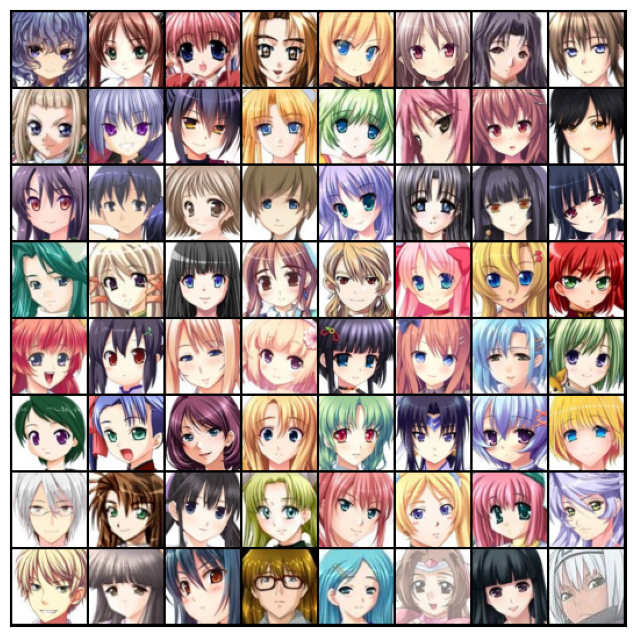

In [43]:
show_batch(train_dl)

**Using a GPU** 

In [44]:
def get_default_device():

    """Pick GPU if available, else CPU"""

    if torch.cuda.is_available():

        return torch.device('cuda')

    else:

        return torch.device('cpu')

    

def to_device(data, device):

    """Move tensor(s) to chosen device"""

    if isinstance(data, (list,tuple)):

        return [to_device(x, device) for x in data]

    return data.to(device, non_blocking=True)



class DeviceDataLoader():

    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):

        self.dl = dl

        self.device = device

        

    def __iter__(self):

        """Yield a batch of data after moving it to device"""

        for b in self.dl: 

            yield to_device(b, self.device)



    def __len__(self):

        """Number of batches"""

        return len(self.dl)

In [45]:
device = get_default_device()

device

device(type='cuda')

In [46]:
train_dl = DeviceDataLoader(train_dl, device)

**Discriminator Network**

In [47]:
import torch.nn as nn

In [48]:
discriminator = nn.Sequential(

    # in: 3 x 64 x 64



    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),

    nn.BatchNorm2d(64),

    nn.LeakyReLU(0.2, inplace=True),

    # out: 64 x 32 x 32



    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),

    nn.BatchNorm2d(128),

    nn.LeakyReLU(0.2, inplace=True),

    # out: 128 x 16 x 16



    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),

    nn.BatchNorm2d(256),

    nn.LeakyReLU(0.2, inplace=True),

    # out: 256 x 8 x 8



    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),

    nn.BatchNorm2d(512),

    nn.LeakyReLU(0.2, inplace=True),

    # out: 512 x 4 x 4



    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),

    # out: 1 x 1 x 1



    nn.Flatten(),

    nn.Sigmoid())

In [49]:
discriminator = to_device(discriminator, device)

**Generator Network**

In [50]:
latent_size = 128

In [51]:
generator = nn.Sequential(

    # in: latent_size x 1 x 1



    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),

    nn.BatchNorm2d(512),

    nn.ReLU(True),

    # out: 512 x 4 x 4



    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),

    nn.BatchNorm2d(256),

    nn.ReLU(True),

    # out: 256 x 8 x 8



    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),

    nn.BatchNorm2d(128),

    nn.ReLU(True),

    # out: 128 x 16 x 16



    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),

    nn.BatchNorm2d(64),

    nn.ReLU(True),

    # out: 64 x 32 x 32



    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),

    nn.Tanh()

    # out: 3 x 64 x 64

)

torch.Size([128, 3, 64, 64])


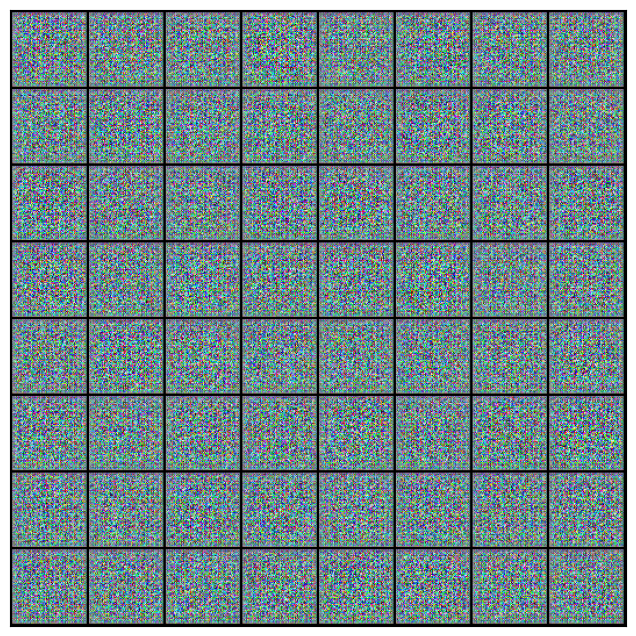

In [52]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors

fake_images = generator(xb)

print(fake_images.shape)

show_images(fake_images)

In [53]:
generator = to_device(generator, device)

**Discriminator Training**

In [54]:
def train_discriminator(real_images, opt_d):

    # Clear discriminator gradients

    opt_d.zero_grad()



    # Pass real images through discriminator

    real_preds = discriminator(real_images)

    real_targets = torch.ones(real_images.size(0), 1, device=device)

    real_loss = F.binary_cross_entropy(real_preds, real_targets)

    real_score = torch.mean(real_preds).item()

    

    # Generate fake images

    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)

    fake_images = generator(latent)



    # Pass fake images through discriminator

    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)

    fake_preds = discriminator(fake_images)

    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)

    fake_score = torch.mean(fake_preds).item()



    # Update discriminator weights

    loss = real_loss + fake_loss

    loss.backward()

    opt_d.step()

    return loss.item(), real_score, fake_score


**Generator Training**

In [55]:
def train_generator(opt_g):

    # Clear generator gradients

    opt_g.zero_grad()

    

    # Generate fake images

    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)

    fake_images = generator(latent)

    

    # Try to fool the discriminator

    preds = discriminator(fake_images)

    targets = torch.ones(batch_size, 1, device=device)

    loss = F.binary_cross_entropy(preds, targets)

    

    # Update generator weights

    loss.backward()

    opt_g.step()

    

    return loss.item()


In [56]:
from torchvision.utils import save_image

In [57]:
sample_dir = 'generated'

os.makedirs(sample_dir, exist_ok=True)

In [58]:
def save_samples(index, latent_tensors, show=True):

    fake_images = generator(latent_tensors)

    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)

    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)

    print('Saving', fake_fname)

    if show:

        fig, ax = plt.subplots(figsize=(8, 8))

        ax.set_xticks([]); ax.set_yticks([])

        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [59]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


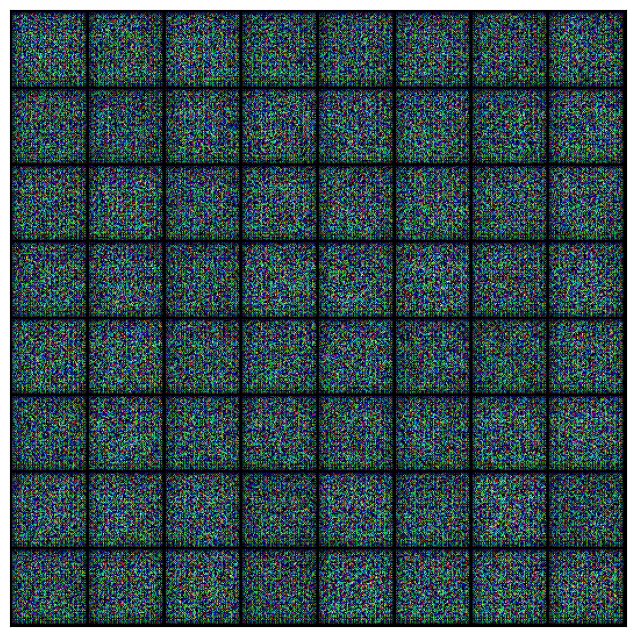

In [60]:
save_samples(0, fixed_latent)

In [61]:
from tqdm.notebook import tqdm

import torch.nn.functional as F

**Training**

In [62]:
def fit(epochs, lr, start_idx=1):

    torch.cuda.empty_cache()

    

    # Losses & scores

    losses_g = []

    losses_d = []

    real_scores = []

    fake_scores = []

    

    # Create optimizers

    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    

    for epoch in range(epochs):

        for real_images, _ in tqdm(train_dl):

            # Train discriminator

            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)

            # Train generator

            loss_g = train_generator(opt_g)

            

        # Record losses & scores

        losses_g.append(loss_g)

        losses_d.append(loss_d)

        real_scores.append(real_score)

        fake_scores.append(fake_score)

        

        # Log losses & scores (last batch)

        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(

            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

    

        # Save generated images

        save_samples(epoch+start_idx, fixed_latent, show=False)

    

    return losses_g, losses_d, real_scores, fake_scores

In [63]:
lr = 0.0002

epochs = 10

In [64]:
history = fit(epochs, lr)

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [1/10], loss_g: 3.1049, loss_d: 0.3295, real_score: 0.7982, fake_score: 0.0662
Saving generated-images-0001.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [2/10], loss_g: 3.6634, loss_d: 0.2079, real_score: 0.8492, fake_score: 0.0261
Saving generated-images-0002.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [3/10], loss_g: 4.5306, loss_d: 0.2804, real_score: 0.8416, fake_score: 0.0806
Saving generated-images-0003.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [4/10], loss_g: 5.7384, loss_d: 0.3018, real_score: 0.9647, fake_score: 0.2214
Saving generated-images-0004.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [5/10], loss_g: 6.7032, loss_d: 0.2423, real_score: 0.9382, fake_score: 0.1493
Saving generated-images-0005.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [6/10], loss_g: 8.6547, loss_d: 0.4736, real_score: 0.9987, fake_score: 0.3180
Saving generated-images-0006.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [7/10], loss_g: 5.7572, loss_d: 0.3060, real_score: 0.9981, fake_score: 0.1956
Saving generated-images-0007.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [8/10], loss_g: 5.5416, loss_d: 0.0921, real_score: 0.9565, fake_score: 0.0434
Saving generated-images-0008.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [9/10], loss_g: 4.0115, loss_d: 0.3644, real_score: 0.7543, fake_score: 0.0076
Saving generated-images-0009.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [10/10], loss_g: 9.2068, loss_d: 0.3258, real_score: 0.9670, fake_score: 0.2188
Saving generated-images-0010.png


In [65]:
losses_g, losses_d, real_scores, fake_scores = history

In [66]:
# Save the model checkpoints 

torch.save(generator.state_dict(), 'G.pth')

torch.save(discriminator.state_dict(), 'D.pth')

In [67]:
from IPython.display import Image

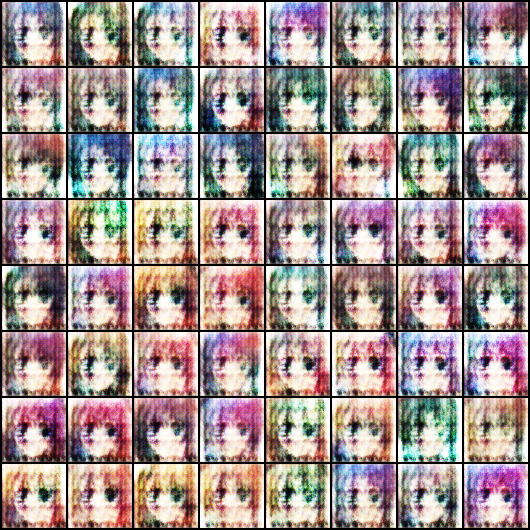

In [68]:
Image('/kaggle/working/generated/generated-images-0001.png')


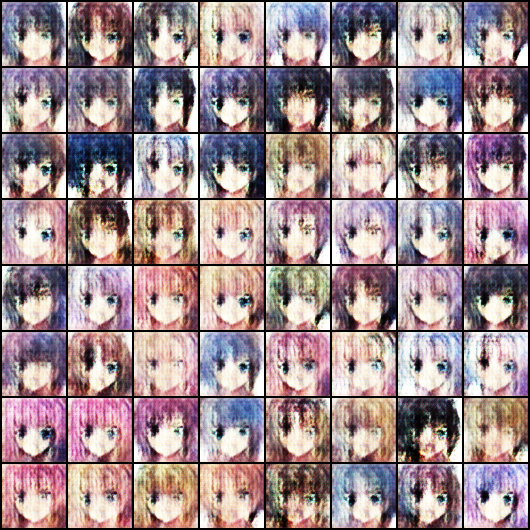

In [69]:
Image('/kaggle/working/generated/generated-images-0002.png')

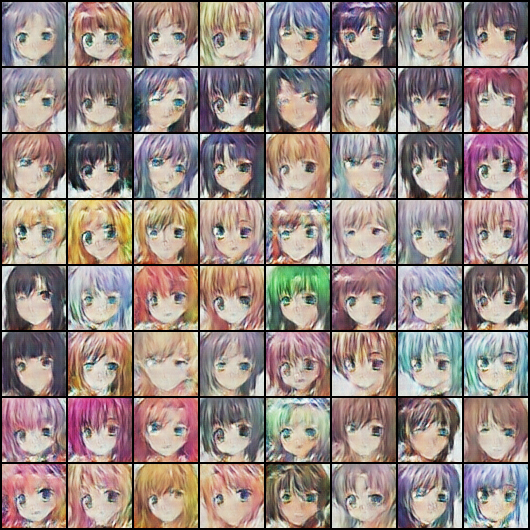

In [70]:
Image('/kaggle/working/generated/generated-images-0010.png')

In [71]:
import cv2

import os



vid_fname = 'gans_training.avi'



files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]

files.sort()



out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 2, (530,530))

[out.write(cv2.imread(fname)) for fname in files]

out.release()

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'avi / AVI (Audio Video Interleaved)'
OpenCV: FFMPEG: fallback to use tag 0x34504d46/'FMP4'


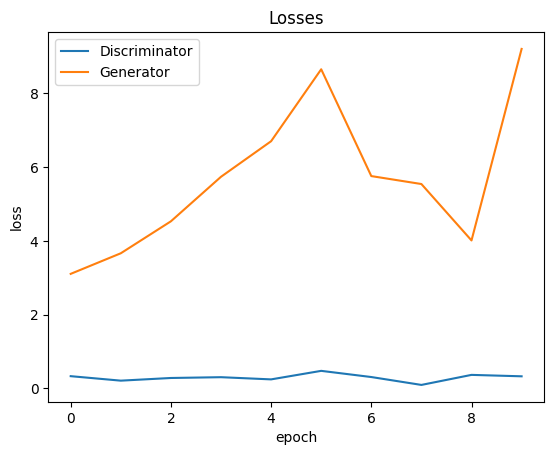

In [72]:
plt.plot(losses_d, '-')

plt.plot(losses_g, '-')

plt.xlabel('epoch')

plt.ylabel('loss')

plt.legend(['Discriminator', 'Generator'])

plt.title('Losses');

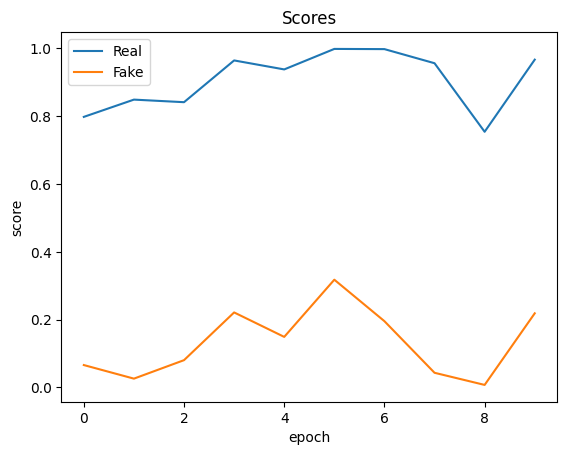

In [73]:
plt.plot(real_scores, '-')

plt.plot(fake_scores, '-')

plt.xlabel('epoch')

plt.ylabel('score')

plt.legend(['Real', 'Fake'])

plt.title('Scores');